Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Clustering documents

This notebook is based on http://www.brandonrose.org and http://www.brandonrose.org/top100  

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

This notebook covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import feature_extraction
import mpld3
import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead

Specifying the path to the files  

In [2]:
datapath = "../datasets/texts/doccluster/"
outputs = "../outputs/"

#### import three lists: titles, links and wikipedia synopses  

In [3]:
titles = open(os.path.join(datapath, 'title_list.txt')).read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]
print(str(len(titles)) + ' titles')

print(titles[0:5])

100 titles
['The Godfather', 'The Shawshank Redemption', "Schindler's List", 'Raging Bull', 'Casablanca']


In [4]:
links = open(os.path.join(datapath, 'link_list_imdb.txt')).read().split('\n')
links = links[:100]
print(str(len(links)) + ' links')

print(links[0:5])

100 links
['http://www.imdb.com/title/tt0068646/', 'http://www.imdb.com/title/tt0111161/', 'http://www.imdb.com/title/tt0108052/', 'http://www.imdb.com/title/tt0081398/', 'http://www.imdb.com/title/tt0034583/']


In [5]:
synopses_wiki = open(os.path.join(datapath, 'synopses_list_wiki.txt')).read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)
synopses_wiki = synopses_clean_wiki

print(str(len(synopses_wiki)) + ' synopses')

print(synopses_wiki[0][0:300])

100 synopses
 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the spra


In [6]:
genres = open(os.path.join(datapath,'genres_list.txt')).read().split('\n')
genres = genres[:100]
print(str(len(genres)) + ' genres')

print(genres[0:5])

100 genres
["[u' Crime', u' Drama']", "[u' Crime', u' Drama']", "[u' Biography', u' Drama', u' History']", "[u' Biography', u' Drama', u' Sport']", "[u' Drama', u' Romance', u' War']"]


In [7]:
synopses_imdb = open(os.path.join(datapath,'synopses_list_imdb.txt')).read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [8]:
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [9]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

### Stopwords, stemming, and tokenizing

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [10]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [12]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [13]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [14]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

### Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 11.3 s, sys: 72 ms, total: 11.4 s
Wall time: 11.4 s
(100, 563)


In [16]:
terms = tfidf_vectorizer.get_feature_names()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [18]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 95.7 ms


In [19]:
from sklearn.externals import joblib

joblib.dump(km, os.path.join(outputs, 'doc_cluster.pkl'))
km = joblib.load(os.path.join(outputs, 'doc_cluster.pkl'))
clusters = km.labels_.tolist()

In [20]:
films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [21]:
frame.head()

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,rank,title,cluster,genre
0,0,The Godfather,0,"[u' Crime', u' Drama']"
4,1,The Shawshank Redemption,4,"[u' Crime', u' Drama']"
0,2,Schindler's List,0,"[u' Biography', u' Drama', u' History']"
0,3,Raging Bull,0,"[u' Biography', u' Drama', u' Sport']"
0,4,Casablanca,0,"[u' Drama', u' Romance', u' War']"


In [22]:
frame['cluster'].value_counts()

4    34
0    28
2    20
1    11
3     7
Name: cluster, dtype: int64

In [23]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    44.821429
1    44.272727
2    42.200000
3    59.428571
4    57.294118
Name: rank, dtype: float64

In [24]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'new', b'father', b'new', b'york', b'brothers',

Cluster 0 titles: The Godfather, Schindler's List, Raging Bull, Casablanca, Citizen Kane, Titanic, The Godfather: Part II, On the Waterfront, The Sound of Music, Amadeus, Gandhi, A Streetcar Named Desire, Doctor Zhivago, The Good, the Bad and the Ugly, High Noon, The Pianist, Goodfellas, City Lights, It Happened One Night, Midnight Cowboy, Rain Man, Annie Hall, Out of Africa, Terms of Endearment, Giant, The Grapes of Wrath, Network, Taxi Driver,

Cluster 1 words: b'ship', b'home', b'killed', b'people', b'away', b'fly',

Cluster 1 titles: The Wizard of Oz, Star Wars, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, Unforgiven, The Best Years of Our Lives, Ben-Hur, The Treasure of the Sierra Madre, Mr. Smith Goes to Washington, Close Encounters of the Third Kind, Mutiny on the Bounty,

Cluster 2 words: b'soldiers', b'army', b'killed', b'war', b'general', b'command',

Cluster 2 titles: 

In [25]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [26]:
#export tables to HTML
html_output = frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False)

from IPython.core.display import display, HTML
display(HTML(html_output))

Rank,Title
9,The Wizard of Oz
20,Star Wars
21,E.T. the Extra-Terrestrial
22,2001: A Space Odyssey
38,Unforgiven
45,The Best Years of Our Lives
47,Ben-Hur
54,The Treasure of the Sierra Madre
70,Mr. Smith Goes to Washington
82,Close Encounters of the Third Kind


### Multidimensional scaling

In [27]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [28]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

### Visualizing document clusters

In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

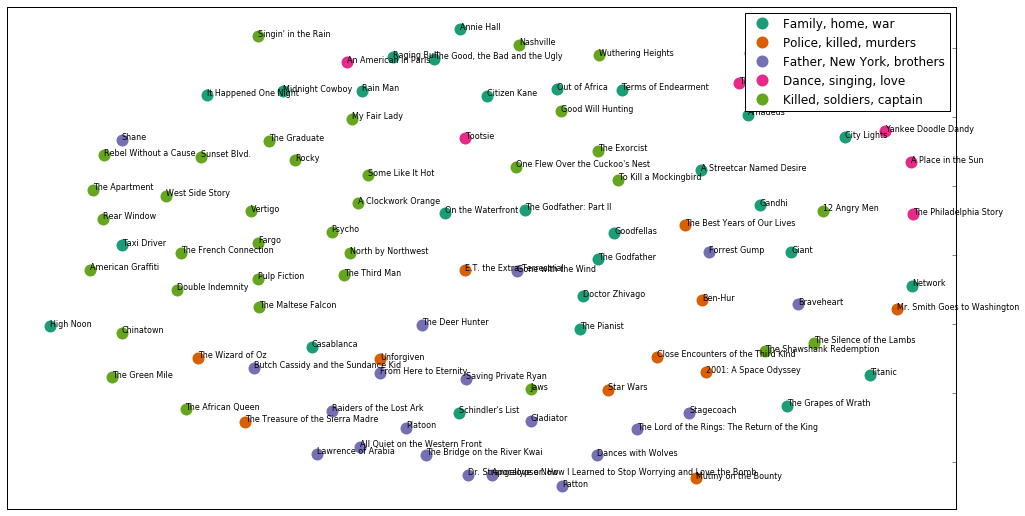

In [30]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

#Saving the Fig
plt.savefig(os.path.join(outputs,'clusters_small_noaxes.png'), dpi=200)

The clustering plot looks great, but it would be better without overlapping labels. We are going to use D3.js (http://d3js.org/), a browser based/javascript interactive. We will use a matplotlib D3 wrapper called mpld3 (https://mpld3.github.io/). Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [31]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [36]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
os.chdir(outputs)
html = mpld3.fig_to_html(fig)
#print(html)

### Hierarchical document clustering

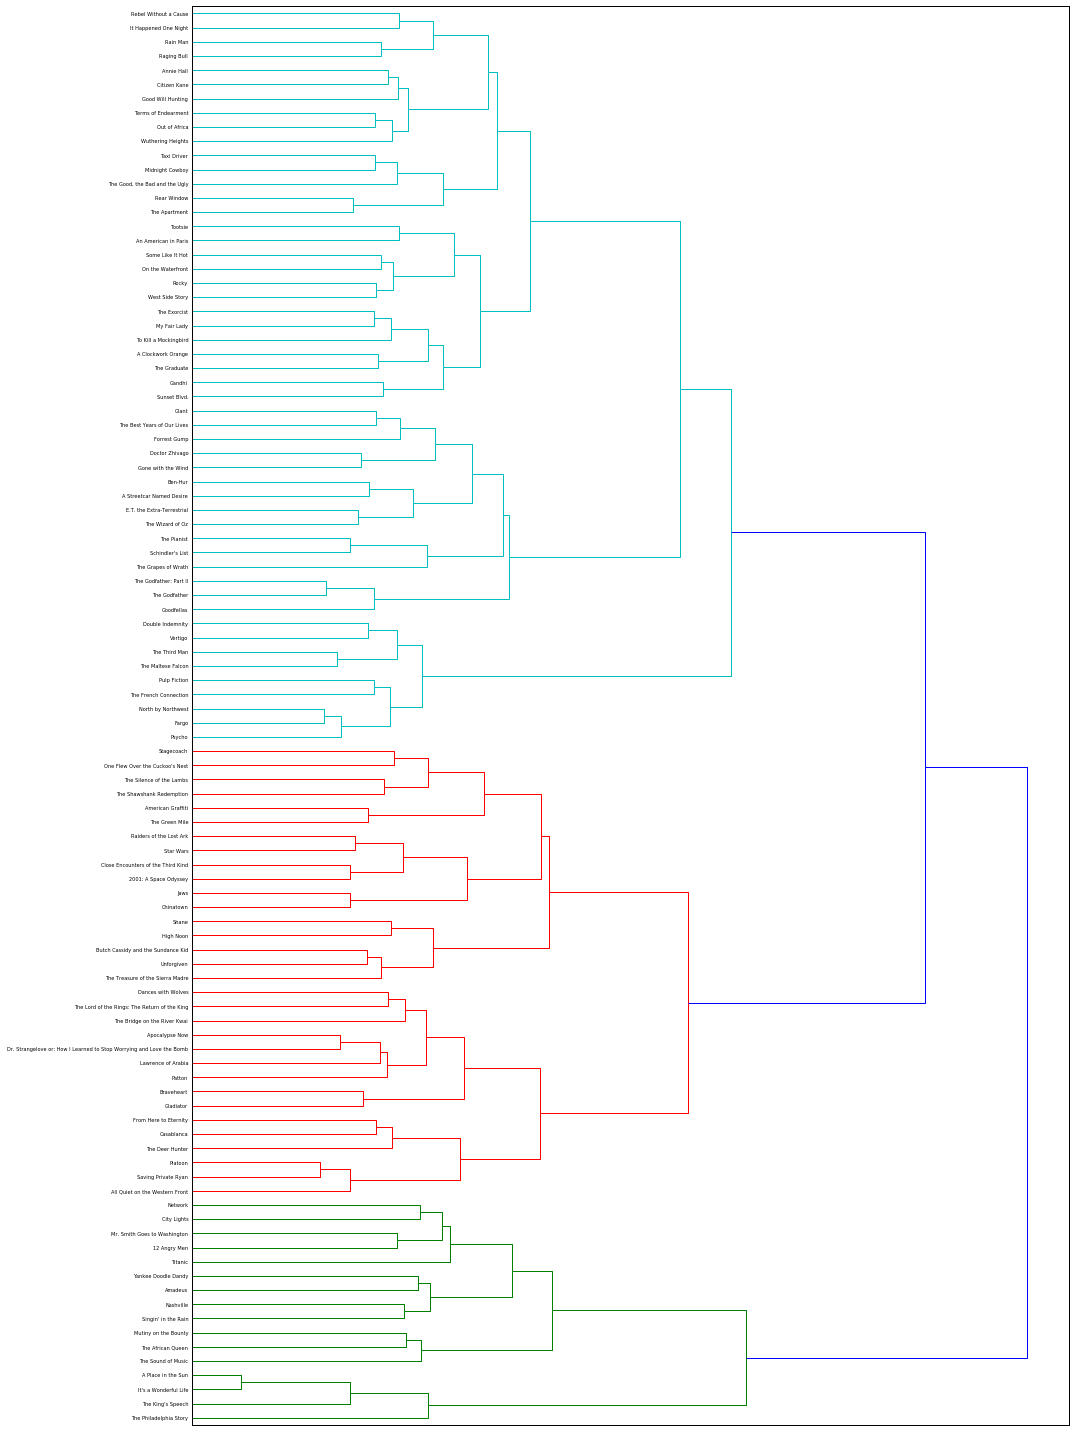

In [38]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig(os.path.join(outputs,'ward_clusters.png'), dpi=200)

### Latent Dirichlet Allocation

In [39]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [40]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [41]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/theano/configparser.py:81: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  'PID': str(os.getpid()),
Using gpu device 0: Quadro K4200 (CNMeM is disabled, cuDNN 5103)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


CPU times: user 4.74 s, sys: 16 ms, total: 4.76 s
Wall time: 4.76 s
CPU times: user 528 ms, sys: 4 ms, total: 532 ms
Wall time: 529 ms


In [42]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [43]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [44]:
len(corpus)

100

In [45]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 6min 3s, sys: 236 ms, total: 6min 4s
Wall time: 6min 3s


In [46]:
print(lda[corpus[0]])

[(1, 0.33548679568041745), (2, 0.35356686173864021), (4, 0.31069842804849057)]


In [47]:
topics = lda.print_topics(5, num_words=20)

In [48]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [49]:
topics_matrix[0]

(0,
 [('soldier', 0.0072537103477050453),
  ('fight', 0.0067897818764374729),
  ('kill', 0.005397397075080722),
  ('friend', 0.0051675512147295851),
  ('go', 0.0050088912566650535),
  ('home', 0.0044828382293420647),
  ('ask', 0.0043435524262012744),
  ('arriv', 0.0041900128918474448),
  ('day', 0.0040737152611987557),
  ('run', 0.0040453512566192935),
  ('love', 0.0038105689314965529),
  ('come', 0.003749448325426966),
  ("n't", 0.0036268890477253136),
  ('villag', 0.003479501979930025),
  ('boat', 0.0034528577400402289),
  ('first', 0.0034489495240845195),
  ('apart', 0.0033732733935460928),
  ('night', 0.0033655219987353607),
  ('away', 0.0032795822170832386),
  ('two', 0.0032466963061001334)])

In [50]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      27.679796        1       1  0.024793  0.007368
1      25.866909        1       2  0.009184  0.086488
3      20.835329        1       3  0.003528 -0.078430
2      13.812185        1       4  0.065221 -0.013605
0      11.805781        1       5 -0.102725 -0.001821, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
4920  Default  198.000000       soldier  198.000000  30.0000  30.0000
5503  Default  110.000000         shark  110.000000  29.0000  29.0000
763   Default  259.000000         fight  259.000000  28.0000  28.0000
2494  Default  112.000000          boat  112.000000  27.0000  27.0000
4234  Default  283.000000          love  283.000000  26.0000  26.0000
2232  Default   79.000000        villag   79.000000  25.0000  25.0000
3980  Default  194.000000         marri  194.000000  24.0000  24.0000
5343  Default   67.000000           wed   67.000000  23.0000  23.0000
4311  Default  141.000000         water  141.000000  22.0000  22.0000
5520  Default   37.000000       platoon   37.000000  21.0000  21.0000
3561  Default  134.000000          ship  134.000000  20.0000  20.0000
5220  Default   46.000000         alien   46.000000  19.0000  19.0000
6091  Default   91.000000       perform   91.000000  18.0000  18.0000
4791  Default   53.000000         river   53.000000  17.0000  17.0000
7137  Default  301.000000           car  301.000000  16.0000  16.0000
2657  Default   61.000000         bridg   61.000000  15.0000  15.0000
4883  Default  105.000000  relationship  105.000000  14.0000  14.0000
584   Default   55.000000           leg   55.000000  13.0000  13.0000
5249  Default  161.000000        prison  161.000000  12.0000  12.0000
1864  Default  205.000000         apart  205.000000  11.0000  11.0000
6933  Default   86.000000          danc   86.000000  10.0000  10.0000
2104  Default  402.000000        friend  402.000000   9.0000   9.0000
510   Default  128.000000       command  128.000000   8.0000   8.0000
6251  Default  596.000000          kill  596.000000   7.0000   7.0000
1895  Default   34.000000           pod   34.000000   6.0000   6.0000
2446  Default  438.000000           ask  438.000000   5.0000   5.0000
5990  Default  150.000000           war  150.000000   4.0000   4.0000
3190  Default   81.000000        affair   81.000000   3.0000   3.0000
7027  Default  191.000000          stop  191.000000   2.0000   2.0000
5039  Default  112.000000          save  112.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
821    Topic5   21.079024       captain   42.484268   1.4357  -6.4860
6933   Topic5   31.979531          danc   86.205503   1.1449  -6.0692
3190   Topic5   30.445394        affair   81.648656   1.1501  -6.1183
5511   Topic5   24.061099         enemi   55.550502   1.2999  -6.3537
2104   Topic5   71.444050        friend  402.892283   0.4068  -5.2654
6712   Topic5   69.250495            go  400.433373   0.3818  -5.2965
1864   Topic5   46.637238         apart  205.121686   0.6554  -5.6919
7027   Topic5   44.857391          stop  191.386288   0.6858  -5.7308
4234   Topic5   52.683073          love  283.281886   0.4544  -5.5700
466    Topic5   55.929059           run  320.170116   0.3918  -5.5102
510    Topic5   35.665319       command  128.834914   0.8522  -5.9601
533    Topic5   61.977541          home  404.062133   0.2618  -5.4075
6251   Topic5   74.621787          kill  596.457798   0.0580  -5.2218
735    Topic5   56.321206           day  353.322135   0.3003  -5.5032
1556   Topic5   57.929081         arriv  376.360739   0.2653  -5.4751
2446   Topic5   60.051844           ask  438.178655   0.1492  -5.4391
3980   Topic5   41.535407         marri  194.245017   0.5940  -5.8077
3329   Topic5   51.838049          come  327.151333   0.2943  -5.5861
2301   To